In [ ]:
!pip install tensorflow
import tensorflow
import numpy as np
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

print("TensorFlow version:", tensorflow.__version__)
print("Keras version:", tensorflow.keras.__version__)

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 675M/675M [00:37<00:00, 21.7MB/s]
100% 675M/675M [00:37<00:00, 18.8MB/s]


In [ ]:
!unzip malaria-dataset.zip

In [ ]:
!unzip cell-images-for-detecting-malaria.zip

In [6]:
import numpy as np


np.random.seed(1000)

import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import keras

os.environ['KERAS_BACKEND'] = 'tensorflow' # Added to set the backend as Tensorflow

In [7]:
image_directory = 'cell_images/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
label = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.
def load_data() :
  parasitized_images = os.listdir(image_directory + 'Parasitized/')
  for i, image_name in enumerate(parasitized_images):    #Remember enumerate method adds a counter and returns the enumerate object

      if (image_name.split('.')[1] == 'png'):
          image = cv2.imread(image_directory + 'Parasitized/' + image_name)
          image = Image.fromarray(image, 'RGB')
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))
          label.append(0)

  #Iterate through all images in Uninfected folder, resize to 64 x 64
  #Then save into the same numpy array 'dataset' but with label 1

  uninfected_images = os.listdir(image_directory + 'Uninfected/')
  for i, image_name in enumerate(uninfected_images):
      if (image_name.split('.')[1] == 'png'):
          image = cv2.imread(image_directory + 'Uninfected/' + image_name)
          image = Image.fromarray(image, 'RGB')
          image = image.resize((SIZE, SIZE))
          dataset.append(np.array(image))
          label.append(1)
load_data()
print(np.shape(dataset))

(27558, 64, 64, 3)


In [8]:
def encode ( x) :
  if x == 0 :
    return "parasitized"
  elif x == 1 :
    return "uninfected"

number of data points 27558


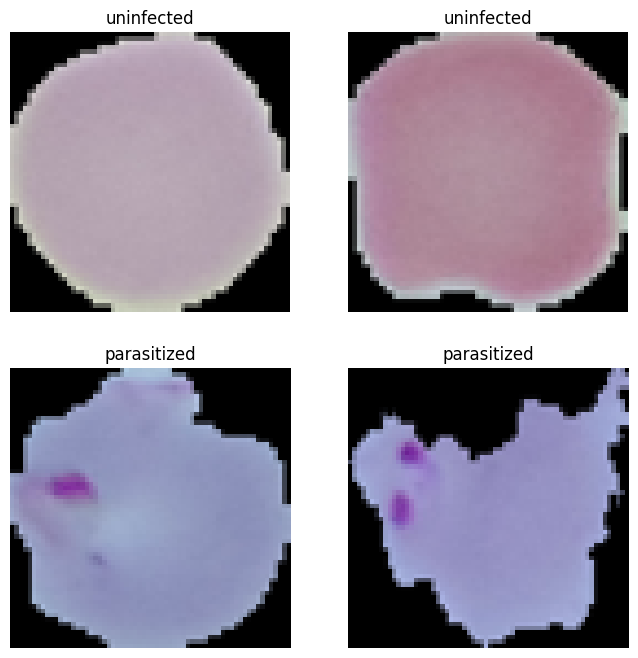

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random

n = len(dataset)  # Change this to your desired upper bound
print('number of data points' , n)

random_indices = [random.randint(0, n) for _ in range(4)]

# Create 4 random image tensors with shape (64, 64, 3)
image_tensors = [dataset[i] for i in random_indices]
image_labels = [encode(label[i]) for i in random_indices ]
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Loop through the image tensors and display them in subplots
for i, ax in enumerate(axs.flat):
    ax.imshow(image_tensors[i])
    ax.set_title(image_labels[i])  # Set title for each subplot
    ax.axis('off')  


plt.show()

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20, random_state = 0)



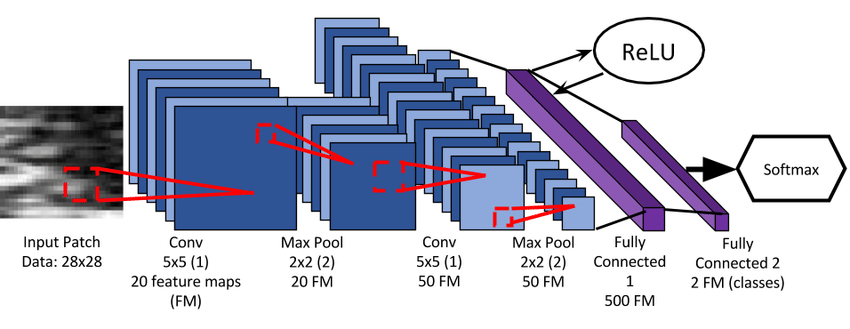

In [11]:
#I messed around with the architecture a little bit to experiment
def build_cnn_model(input_shape):
    cnn_model = tensorflow.keras.Sequential([
        Input (input_shape) ,

        Conv2D(filters=24, kernel_size=(3,3)),
        LeakyReLU(alpha = 0.2),
        MaxPool2D(pool_size=(2,2)),
        BatchNormalization(momentum = 0.8),



        Conv2D(filters=36, kernel_size=(3,3)),
        LeakyReLU(alpha = 0.2),
        MaxPool2D(pool_size=(2,2)),
        BatchNormalization(momentum = 0.8),

        Flatten(),
        Dropout(0.1),
        Dense(128),
        LeakyReLU(alpha = 0.2),
        BatchNormalization(),

        Dense(2, activation=tensorflow.nn.softmax)

    ])

    return cnn_model

cnn_model = build_cnn_model((SIZE , SIZE , 3))
cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 24)        672       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 62, 62, 24)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 24)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 24)       96        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 36)        7812      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 29, 29, 36)        0

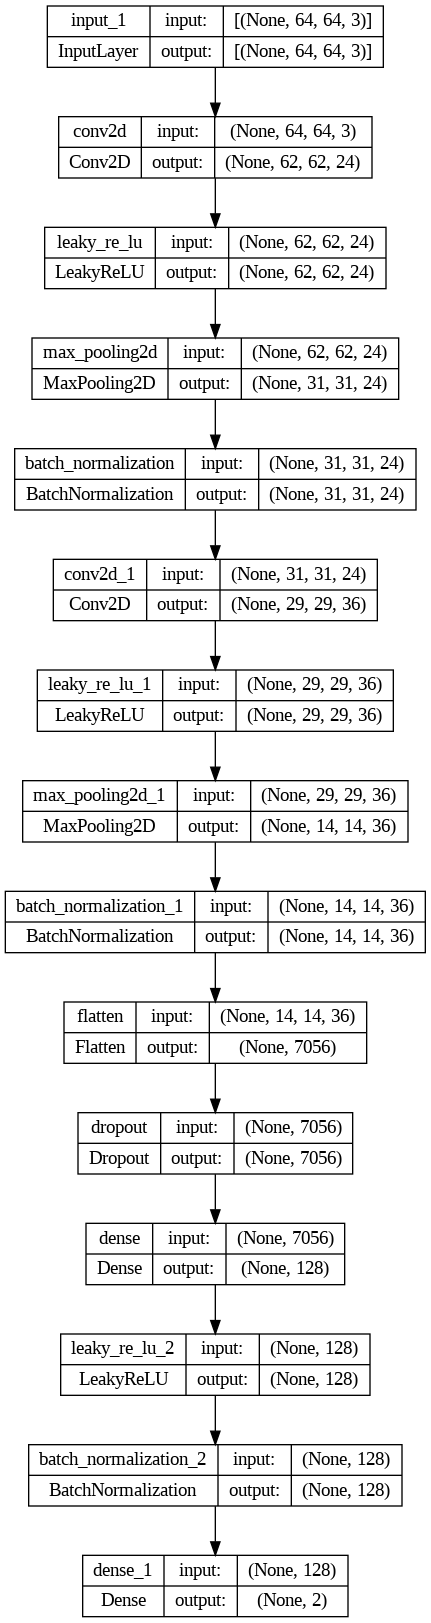

In [12]:
plot_model(cnn_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [20]:

cnn_model.compile(optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(np.array(X_train),
                         y_train,
                         batch_size = 64,
                         verbose = 1,
                         epochs = 50,      
                         validation_split = 0.1,
                         shuffle = False
                      
                     )

173/173 [==============================] - 1s 5ms/step - loss: 0.2031 - accuracy: 0.9336
Test_Accuracy: 93.36%


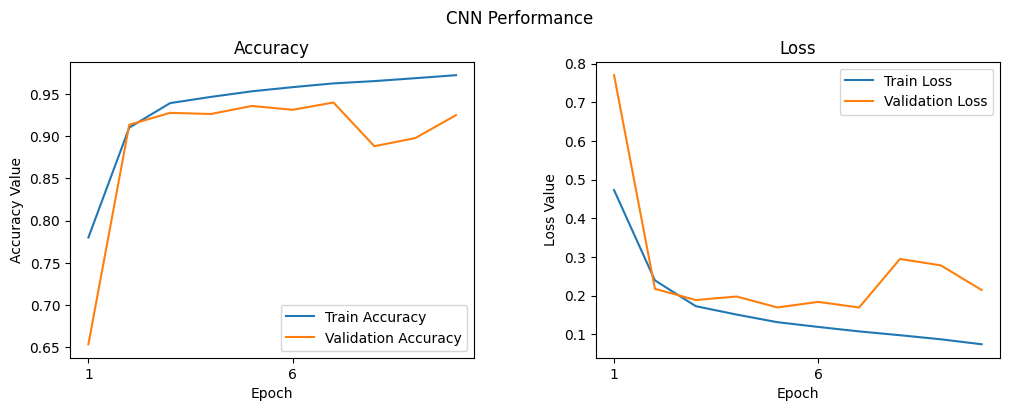

In [19]:
print("Test_Accuracy: {:.2f}%".format(cnn_model.evaluate(np.array(X_test), np.array(y_test))[1]*100))




f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [50]:
def phi (label) :
  if label[1] > label[0] :
    return "M_NEG"
  else :
    return "M_POS"

173/173 [==============================] - 1s 5ms/step


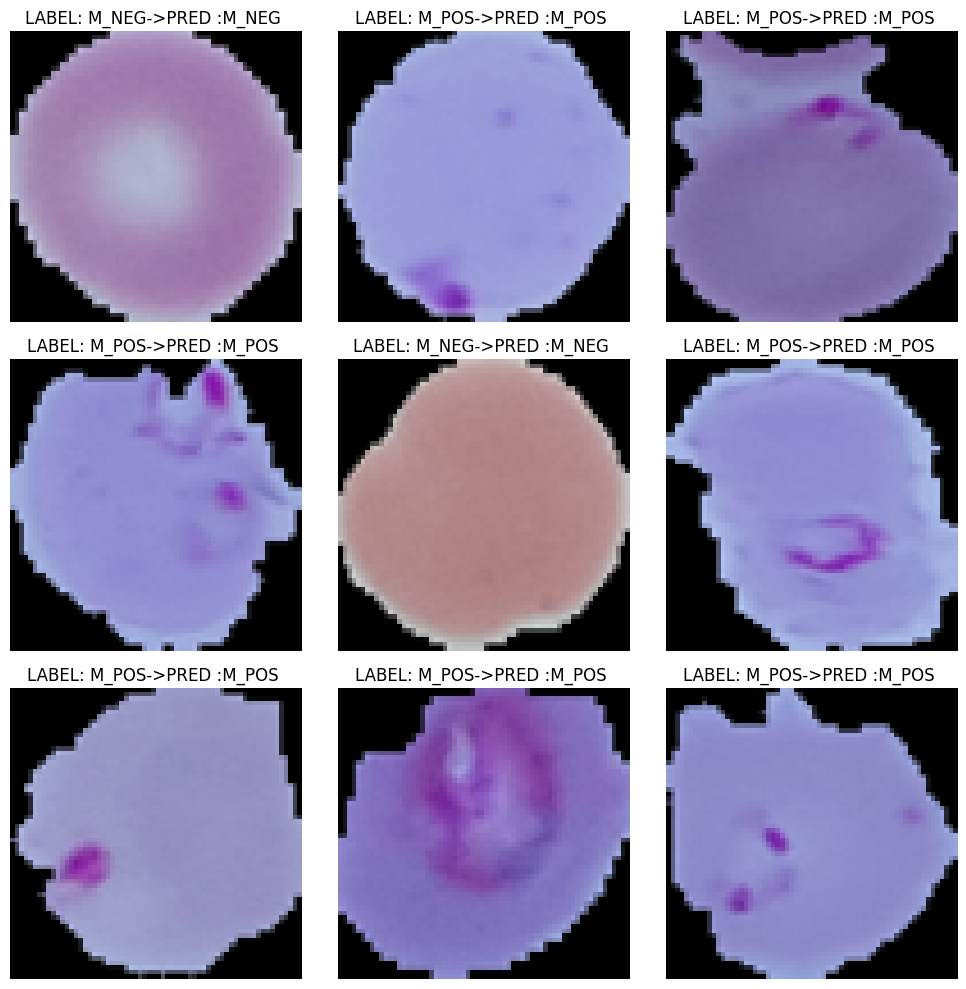

In [58]:

predictions = cnn_model.predict(np.array(X_test))


idx = [random.randint(0 , len(X_test) - 1 ) for _ in range (9) ]
X_plot = [X_test[i] for i in idx ]
y_plot = [y_test[i] for i in idx ]
pred_plot = [predictions[i] for i in idx ]
fig, axs = plt.subplots(3, 3, figsize=(10, 10))



for i, ax in enumerate(axs.flat):
    ax.imshow(X_plot[i])
    ax.set_title(f"LABEL: {phi(y_plot[i])}->PRED :{phi(pred_plot[i])} ")  # Set title for each subplot

    ax.axis('off')  

plt.tight_layout()